In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os

In [ ]:


def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target



In [ ]:
imgs = list(sorted(os.listdir("/content/drive/MyDrive/Datasets/face-mask-detection/images/")))

In [ ]:
labels = list(sorted(os.listdir("/content/drive/MyDrive/Datasets/face-mask-detection/annotations/")))

In [ ]:


class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("/content/drive/MyDrive/Datasets/face-mask-detection/images/")))
#         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/content/drive/MyDrive/Datasets/face-mask-detection/images/", file_image)
        label_path = os.path.join("/content/drive/MyDrive/Datasets/face-mask-detection/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)



In [ ]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([0, 1, 0], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 2], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

In [ ]:
num_epochs = 25
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)

tensor(87.6738, device='cuda:0', grad_fn=<AddBackward0>)
tensor(60.4677, device='cuda:0', grad_fn=<AddBackward0>)
tensor(49.5005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(46.1416, device='cuda:0', grad_fn=<AddBackward0>)
tensor(41.9592, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.7348, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.3048, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.2568, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.6430, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.4528, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.2633, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.1485, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.0913, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.1072, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.6318, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.5809, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.8653, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.1786, device='cuda:0'

In [ ]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [ ]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[184.8298,  98.0268, 226.3091, 145.2160]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9938], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[222.5494,  35.1917, 259.6711,  74.9728],
          [317.5558,  32.6049, 352.2755,  70.4926],
          [142.2770,  74.6457, 173.9438, 113.6820],
          [ 19.7731,  71.9023,  42.3213,  93.2236],
          [297.0880,  58.5053, 313.5239,  80.0629],
          [191.3785,  64.4096, 216.3012,  95.0646],
          [366.2019,  70.2725, 389.6355,  96.6242]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9945, 0.9921, 0.9915, 0.9716, 0.9564, 0.9552, 0.5599],
         device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[ 71.6557,  40.9264, 100.0434,  70.0850],
          [153.4269,  47.3550, 175.8651,  74.7592],
          [237.6253,  32.5775, 261.471

In [ ]:
a = preds[2]
for box in a["boxes"]:
  xmin, ymin, xmax, ymax = box
  print(xmin, ymin, xmax, ymax)

tensor(71.6557, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(40.9264, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(100.0434, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(70.0850, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(153.4269, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(47.3550, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(175.8651, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(74.7592, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(237.6253, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(32.5775, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(261.4713, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(70.4941, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(330.1708, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(31.6492, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(368.2726, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(66.1945, device='cuda:0', grad_fn=<UnbindBackward0>)
tensor(332.1796, device='cuda:0',

In [ ]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box.cpu().detach().numpy()
        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


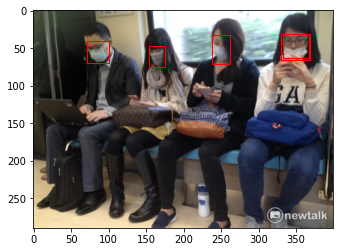

Target


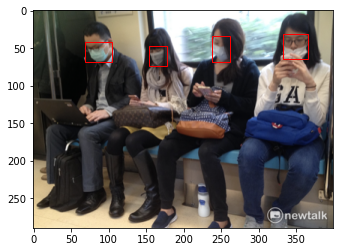

In [ ]:
print("Prediction")
plot_image(imgs[2], preds[2])
print("Target")
plot_image(imgs[2], annotations[2])

In [ ]:
torch.save(model.state_dict(),'model.pt')

In [ ]:
model2 = get_model_instance_segmentation(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model2.load_state_dict(torch.load('model.pt'))
model2.eval()
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
pred2 = model2(imgs)

Predict with loaded model


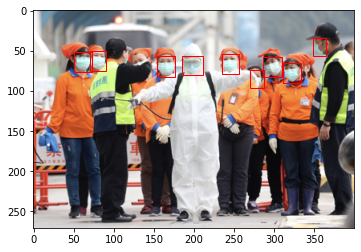

In [ ]:
print("Predict with loaded model")
plot_image(imgs[3], pred2[3])